## Refernce
[Paper](https://www.sciencedirect.com/science/article/abs/pii/S0010482518302713) <br>
[Link](https://github.com/tom-beer/Arrhythmia-CNN)

In [779]:
# from google.colab import drive
# drive.mount('/content/drive')

In [780]:
# !git clone https://github.com/tom-beer/Arrhythmia-CNN.git
# %cd Arrhythmia-CNN/

In [781]:
from __future__ import print_function
import torch
import torch.utils.data
import numpy as np
import pandas as pd

from torch import nn, optim
from torch.utils.data.dataset import Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


# is_cuda = False
is_cuda = True
num_epochs = 300
# num_epochs = 50
batch_size = 10
weight_decay=1e-4
lr = 1e-2
# lr = 3e-1
# lr = 1e-3
# torch.manual_seed(46)
log_interval = 10
in_channels_ = 1
num_segments_in_record = 100
segment_len = 3600
num_records = 48
# num_classes = 16
num_classes = 16
allow_label_leakage = True

device = torch.device("cuda:0" if is_cuda else "cpu")

In [782]:
# train_ids, test_ids = train_test_split(np.arange(index_set), train_size=.8, random_state=46)
# scaler = MinMaxScaler(feature_range=(0, 1), copy=False)

class CustomDatasetFromCSV(Dataset):
    def __init__(self, data_path, transforms_=None):
        self.df = pd.read_pickle(data_path)
        self.transforms = transforms_

    def __getitem__(self, index):
        row = self.df.iloc[index]
        signal = row['signal']
        target = row['target']
        if self.transforms is not None:
            signal = self.transforms(signal)
        signal = signal.reshape(1, signal.shape[0])
        return signal, target

    def ddd(self):
        df_=self.df
        # print(df_)
        df_=df_.reindex(np.random.permutation(df_.index)).T
        # print(df_)
        counts_=[0]*16
        df_.drop(labels=['symbol'])
        for key_ in df_:
            # print(counts_)
            if counts_[df_[key_][-2]]<10:
                counts_[df_[key_][-2]]+=1
            else:
                df_=df_.drop(columns=[key_])
        # print(df_.shape)
        self.df=df_.T
        
    def __len__(self):
        return self.df.shape[0]


train_dataset = CustomDatasetFromCSV('/content/drive/MyDrive/Arrhythmia-CNN-master/data/Arrhythmia_dataset.pkl')
# train_dataset.ddd()
# train_dataset = CustomDatasetFromCSV('/content/drive/MyDrive/Arrhythmia-CNN-master/data/Arrhythmia_dataset_yystest_noseed1.pkl')
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1, shuffle=False)
test_dataset = CustomDatasetFromCSV('/content/drive/MyDrive/Arrhythmia-CNN-master/data/Arrhythmia_dataset.pkl')
# test_dataset = CustomDatasetFromCSV('/content/drive/MyDrive/Arrhythmia-CNN-master/data/Arrhythmia_dataset_yystest.pkl')
# test_dataset = CustomDatasetFromCSV('/content/drive/MyDrive/Arrhythmia-CNN-master/data/Arrhythmia_dataset_yystest_noseed1.pkl')
# test_dataset.ddd()


train_dataset


test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)


print(train_dataset.df)
# print(test_dataset.df)
# df_=train_dataset.df.T
# for key_ in df_:
#   row_=df_[key_]
#   data_=row_[2]
#   break
#   # print(data_)
# count_=0
# for num_ in data_:
#   print(num_,end='\t')
#   count_+=1
#   count_%=630
#   if count_==0:
#     print(' #')

     record_id        label  ... target  target_str
1255       108  Normal beat  ...      0           N
4862       213  Normal beat  ...      0           N
5127       215  Normal beat  ...      0           N
848        106  Normal beat  ...      0           N
3088       122  Normal beat  ...      0           N
...        ...          ...  ...    ...         ...
473        102   Paced beat  ...     11           P
485        102   Paced beat  ...     11           P
5198       217   Paced beat  ...     11           P
378        102   Paced beat  ...     11           P
5208       217   Paced beat  ...     11           P

[823 rows x 8 columns]


In [783]:



class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)


def basic_layer(in_channels, out_channels, kernel_size, batch_norm=False, max_pool=True, conv_stride=1, padding=0
                , pool_stride=2, pool_size=2):
    layer = nn.Sequential(
        nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=conv_stride,
                  padding=padding),
        nn.ReLU())
    if batch_norm:
        layer = nn.Sequential(
            layer,
            nn.BatchNorm1d(num_features=out_channels))
    if max_pool:
        layer = nn.Sequential(
            layer,
            nn.MaxPool1d(kernel_size=pool_size, stride=pool_stride))

    return layer


class arrhythmia_classifier(nn.Module):
    def __init__(self, in_channels=in_channels_):
        # print(in_channels_)
        super(arrhythmia_classifier, self).__init__()
        self.cnn = nn.Sequential(
          
            basic_layer(in_channels=in_channels, out_channels=128, kernel_size=50, batch_norm=True, max_pool=True,
                        conv_stride=3, pool_stride=3),
            basic_layer(in_channels=128, out_channels=32, kernel_size=7, batch_norm=True, max_pool=True,
                        conv_stride=1, pool_stride=2),
            basic_layer(in_channels=32, out_channels=32, kernel_size=10, batch_norm=False, max_pool=False,
                        conv_stride=1),
            basic_layer(in_channels=32, out_channels=128, kernel_size=5, batch_norm=False, max_pool=True,
                        conv_stride=2, pool_stride=2),
            basic_layer(in_channels=128, out_channels=256, kernel_size=15, batch_norm=False, max_pool=True,
                        conv_stride=1, pool_stride=2),
            basic_layer(in_channels=256, out_channels=512, kernel_size=5, batch_norm=False, max_pool=False,
                        conv_stride=1),
            basic_layer(in_channels=512, out_channels=128, kernel_size=3, batch_norm=False, max_pool=False,
                        conv_stride=1),
            Flatten(),
            nn.Linear(in_features=1152, out_features=512),
            nn.ReLU(),
            nn.Dropout(p=.1),
            nn.Linear(in_features=512, out_features=num_classes),
            nn.Softmax(dim=1)


            # nn.Linear(in_features=3600, out_features=128),
            # nn.ReLU(True),
            # nn.Linear(in_features=128, out_features=32),
            # nn.ReLU(True),
            # nn.Linear(in_features=32, out_features=num_classes),
            # nn.Softmax(dim=0)


            # nn.Linear(3600, out_features=256), 
            # nn.ReLU(True),
            # nn.Linear(256, out_features=64), 
            # nn.ReLU(True),
            # nn.Linear(64, num_classes),
            # nn.Softmax(dim=1)
        )
        # self.layer1 = nn.Sequential(nn.Linear(3600, out_features=256), nn.ReLU(True))
        # self.layer2 = nn.Sequential(nn.Linear(256, out_features=64), nn.ReLU(True))
        # self.layer3 = nn.Sequential(nn.Linear(64, out_features=16), nn.ReLU(True))
        # self.layer4 = nn.Sequential(nn.Linear(16, num_classes) )
        self.layer1 =nn.Sequential(
            basic_layer(in_channels=in_channels, out_channels=19, kernel_size=50, batch_norm=True, max_pool=True,
                        conv_stride=3, pool_stride=3),
            # basic_layer(in_channels=128, out_channels=32, kernel_size=7, batch_norm=True, max_pool=True,
            #             conv_stride=1, pool_stride=2),
            # basic_layer(in_channels=32, out_channels=32, kernel_size=10, batch_norm=False, max_pool=False,
            #             conv_stride=1),
            # basic_layer(in_channels=32, out_channels=128, kernel_size=5, batch_norm=False, max_pool=True,
            #             conv_stride=2, pool_stride=2),
            # basic_layer(in_channels=128, out_channels=256, kernel_size=15, batch_norm=False, max_pool=True,
            #             conv_stride=1, pool_stride=2),
            # basic_layer(in_channels=256, out_channels=512, kernel_size=5, batch_norm=False, max_pool=False,
            #             conv_stride=1),
            # basic_layer(in_channels=512, out_channels=128, kernel_size=3, batch_norm=False, max_pool=False,
            #             conv_stride=1),
            Flatten()
        )
        self.layer2 =nn.Sequential(nn.Linear(in_features=7505, out_features=512),nn.ReLU())
        self.layer2 =nn.Sequential(self.layer2,nn.Linear(in_features=512, out_features=13),nn.ReLU())
        # self.layer2 =nn.Sequential(nn.Linear(in_features=5925, out_features=15),nn.ReLU())
        # self.layer2 =nn.Sequential(self.layer2,nn.Linear(in_features=395, out_features=15),nn.ReLU())
        # self.layer2 =nn.Sequential(nn.Linear(in_features=50560, out_features=15),nn.ReLU())
        # self.layer2 =nn.Sequential(self.layer2,nn.Linear(in_features=240, out_features=15),nn.ReLU())
        # self.layer2 =nn.Sequential(nn.Linear(in_features=1152, out_features=395),nn.ReLU())
        # self.layer2 =nn.Sequential(self.layer2,nn.Linear(in_features=395, out_features=15),nn.ReLU())
        self.layer3 =nn.Linear(in_features=13, out_features=num_classes)
        # self.layer4 =nn.Softmax(dim=1)

    def forward(self, x, ex_features=None):

        # x=x[0]
        x = self.layer1(x)
        # print(x.shape)
        x = self.layer2(x)
        # print(x.shape)
        x = self.layer3(x)
        # print(x.shape)
        # x = self.layer4(x)
        return x


        # return self.cnn(x)


def calc_next_len_conv1d(current_len=112500, kernel_size=16, stride=8, padding=0, dilation=1):
    return int(np.floor((current_len + 2 * padding - dilation * (kernel_size - 1) - 1) / stride + 1))


model = arrhythmia_classifier().to(device).double()


num_of_iteration = len(train_dataset) // batch_size

# optimizer = optim.Adam(model.parameters(), lr=0.0003)
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.000001)
# optimizer = optim.Adam(model.parameters(), lr=1)
# optimizer = optim.Adam(model.parameters(), lr=0.3, weight_decay=1e-6)
# optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
# optimizer = optim.Adam(model.parameters(), lr=1, weight_decay=weight_decay)
# optimizer = optim.Adam(model.parameters())
# optimizer = optim.Adadelta(model.parameters())
# optimizer = optim.SGD(model.parameters(),lr=3e-1)
# optimizer = optim.SGD(model.parameters(),lr=3e-4)
# optimizer = optim.SGD(model.parameters(), lr=0.0003, weight_decay=0.00006)

# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()


def train(epoch):
    model.train()
    train_loss = 0
    all_=0
    t_=0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        # if batch_idx % log_interval == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_loader.dataset),
        #                100. * batch_idx / len(train_loader),
        #                loss.item() / len(data)))
        list_=output[0].tolist()
        pridict_=int(list_.index(max(list_)))
        for target_ in target:
            all_+=1
            if int(target_)==pridict_:
                t_+=1
        if all_//10>(all_-1)//10:
          print('-',end='')

    accuracy_=t_/all_
    print('\n====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)))
    print('====> Epoch: {} Accuracy: {:.4f}'.format(
        epoch, accuracy_))
    # torch.save(model,f"/content/drive/MyDrive/meeting_ECG/save_model/lr{str(lr).replace('.','')}_epoch{epoch}.pt")


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        all_=0
        t_=0
        count_p=[0]*16
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()

            # if batch_idx == 0:
            #     n = min(data.size(0), 4)

            list_=output[0].tolist()
            pridict_=int(list_.index(max(list_)))
            for target_ in target:
                all_+=1
                if int(target_)==pridict_:
                    t_+=1
              
            _, pridict_ = torch.max(output.data, 1)
            pridict_ = int(pridict_[0])
            count_p[pridict_]+=1
    accuracy_=t_/all_
    print('====> Test set loss: {:.5f}'.format(test_loss/len(test_loader.dataset)))
    print('====> Test Accuracy: {:.5f}'.format(accuracy_))
    print(count_p,'\n')
    # print(f'Learning rate: {optimizer.param_groups[0]["lr"]:.6f}')


num_epochs=500
batch_size=13
# batch_size=5
# batch_size=batch_size
for epoch in range(1, num_epochs + 1):
  train_dataset = CustomDatasetFromCSV('/content/drive/MyDrive/Arrhythmia-CNN-master/data/Arrhythmia_dataset_yystest_noseed1.pkl')
  train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
  train(epoch)
  # test(epoch)
  train_dataset = CustomDatasetFromCSV('/content/drive/MyDrive/Arrhythmia-CNN-master/data/Arrhythmia_dataset_yystest_noseed2.pkl')
  train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
  train(epoch)
  # test(epoch)
  train_dataset = CustomDatasetFromCSV('/content/drive/MyDrive/Arrhythmia-CNN-master/data/Arrhythmia_dataset_yystest_noseed3.pkl')
  train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
  train(epoch)
  # test(epoch)
  train_dataset = CustomDatasetFromCSV('/content/drive/MyDrive/Arrhythmia-CNN-master/data/Arrhythmia_dataset_yystest_noseed4.pkl')
  train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
  train(epoch)
  # test(epoch)
  train_dataset = CustomDatasetFromCSV('/content/drive/MyDrive/Arrhythmia-CNN-master/data/Arrhythmia_dataset_yystest_noseed5.pkl')
  train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
  train(epoch)

  print('==========================================================')
  test(epoch)

------
====> Epoch: 1 Average loss: 0.2310
====> Epoch: 1 Accuracy: 0.2491
------
====> Epoch: 1 Average loss: 0.2139
====> Epoch: 1 Accuracy: 0.2151
------
====> Epoch: 1 Average loss: 0.1965
====> Epoch: 1 Accuracy: 0.2102
------
====> Epoch: 1 Average loss: 0.1702
====> Epoch: 1 Accuracy: 0.2928
------
====> Epoch: 1 Average loss: 0.1535
====> Epoch: 1 Accuracy: 0.3645
====> Test set loss: 1.82694
====> Test Accuracy: 0.36452
[162, 84, 12, 193, 17, 15, 15, 3, 0, 121, 17, 184, 0, 0, 0, 0] 

------
====> Epoch: 2 Average loss: 0.1369
====> Epoch: 2 Accuracy: 0.3135
------
====> Epoch: 2 Average loss: 0.1177
====> Epoch: 2 Accuracy: 0.5213
------
====> Epoch: 2 Average loss: 0.1067
====> Epoch: 2 Accuracy: 0.4860
------
====> Epoch: 2 Average loss: 0.0939
====> Epoch: 2 Accuracy: 0.5796
------
====> Epoch: 2 Average loss: 0.0797
====> Epoch: 2 Accuracy: 0.5699
====> Test set loss: 1.01404
====> Test Accuracy: 0.68773
[264, 61, 8, 143, 23, 51, 3, 3, 1, 137, 62, 66, 0, 0, 1, 0] 

------


KeyboardInterrupt: ignored

In [784]:
torch.save(model,f"/content/drive/MyDrive/meeting_ECG/save_model/temp.pt")

In [820]:
num_labels_dict = {
    'Normal beat': 283,  # N
    'Left bundle branch block beat': 103,  # L
    'Atrial premature beat': 66,  # A
    'Atrial flutter': 20,  # (AFL (aux)
    'Atrial fibrillation': 135,  # (AFIB (aux)
    'Pre-excitation (WPW)': 21,  # (PREX (aux)
    'Premature ventricular contraction': 133,  # V
    'Ventricular bigeminy': 55,  # (B (aux)
    'Ventricular trigeminy': 13,  # (T (aux)
    'Ventricular tachycardia': 10,  # (VT (aux)
    'Idioventricular rhythm': 10,  # (IVR (aux)
    'Ventricular flutter': 10,  # (VFL (aux)
    'Fusion of ventricular and normal beat': 11,  # F
    'Second-degree heart block': 10,  # SHB
    'Pacemaker rhythm': 45,  # P
    'Supraventricular tachyarrhythmia': 13,  # (SVTA (aux)
    'Right bundle branch block beat': 62,  # R
}
num_labels_we_have = {
    'N': 283,  # 'Normal beat'
    'L': 103,  # 'Left bundle branch block beat'
    'A': 66,  # 'Atrial premature beat':
    # 'V': 133, # 'Premature ventricular contraction'
    # 'SHB': 10,  # 'Second-degree heart block'
    # 'F': 11,  # 'Fusion of ventricular and normal beat'
    'R': 62,  # 'Right bundle branch block beat'
    'AFL': 20,  # 'Atrial flutter'
    'AFIB': 135,  # 'Atrial fibrillation'
    'PREX': 21,  # 'Pre-excitation (WPW)'
    'B': 55,  # 'Ventricular bigeminy'
    'T': 13,  # 'Ventricular trigeminy'
    # '(VT'   : 10,  # 'Ventricular tachycardia'
    'IVR': 10,  # 'Idioventricular rhythm'
    'VFL': 10,  # 'Ventricular flutter'
    'P': 45  # 'Pacemaker rhythm'
    # '(SVTA' : 13  # 'Supraventricular tachyarrhythmia'
}
dict_mapping={
    'Normal beat': 'N',
    'Atrial premature beat': 'A',
    'Atrial flutter': 'AFL',
    'Atrial fibrillation': 'AFIB',
    'Pre-excitation (WPW)': 'PREX',
    'Ventricular bigeminy': 'B',
    'Ventricular trigeminy': 'T',
    'Idioventricular rhythm': 'IVR',
    'Ventricular flutter': 'VFL',
    'Left bundle branch block beat': 'L',
    'Right bundle branch block beat': 'R',
    'Pacemaker rhythm': 'P',
    # 'Premature ventricular contraction': 'V',
    # 'Ventricular tachycardia': 'VT',
    # 'Fusion of ventricular and normal beat': 'F',
    # 'Second-degree heart block': 'SHB',
    # 'Supraventricular tachyarrhythmia': 'SVTA',
    '13':'13',
    '14':'14',
    '15':'15',
    '16':'16',
    # '17':'17',
}
label_numeric_dict = {
    'N': 0,
    'A': 1,
    'AFL': 2,
    'AFIB': 3,
    'PREX': 4,
    'B': 5,
    'T': 6,
    'IVR': 7,
    'VFL': 8,
    'L': 9,
    'R': 10,
    'P': 11
}
classes_=len(dict_mapping)



# model=torch.load("/content/drive/MyDrive/meeting_ECG/save_model/lr03_epoch8.pt")
model=torch.load("/content/drive/MyDrive/meeting_ECG/save_model/temp.pt")


# test_dataset = CustomDatasetFromCSV('/content/drive/MyDrive/Arrhythmia-CNN-master/data/Arrhythmia_dataset.pkl')
test_dataset = CustomDatasetFromCSV('/content/drive/MyDrive/Arrhythmia-CNN-master/data/Arrhythmia_dataset_yystest.pkl')
# test_dataset = CustomDatasetFromCSV('/content/drive/MyDrive/Arrhythmia-CNN-master/data/Arrhythmia_dataset_yystest_noseed1.pkl')
# test_dataset = CustomDatasetFromCSV('/content/drive/MyDrive/Arrhythmia-CNN-master/data/Arrhythmia_dataset_yystest_noseed2.pkl')
# test_dataset = CustomDatasetFromCSV('/content/drive/MyDrive/Arrhythmia-CNN-master/data/Arrhythmia_dataset_yystest_noseed3.pkl')
# test_dataset = CustomDatasetFromCSV('/content/drive/MyDrive/Arrhythmia-CNN-master/data/Arrhythmia_dataset_yystest_noseed4.pkl')
# test_dataset = CustomDatasetFromCSV('/content/drive/MyDrive/Arrhythmia-CNN-master/data/Arrhythmia_dataset_yystest_noseed5.pkl')
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
print(test_dataset.df)


# conf_matrix = torch.zeros(classes_,classes_)
truth_prediction_matrix=torch.zeros(num_classes,num_classes)
print(truth_prediction_matrix.shape)
count_=[0]*num_classes
count_p=[0]*num_classes

model.eval()
test_loss = 0
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        # print(int(target))
        count_[int(target)]+=1

        _, pridict_ = torch.max(output.data, 1)
        pridict_ = int(pridict_[0])
        count_p[pridict_]+=1
        truth_prediction_matrix[target,pridict_]+=1

print(count_)
print(count_p)
# print(truth_prediction_matrix)

     record_id        label  ... target  target_str
2878       121  Normal beat  ...      0           N
5557       220  Normal beat  ...      0           N
5794       222  Normal beat  ...      0           N
6072       228  Normal beat  ...      0           N
6078       228  Normal beat  ...      0           N
...        ...          ...  ...    ...         ...
1023       107   Paced beat  ...     11           P
479        102   Paced beat  ...     11           P
1022       107   Paced beat  ...     11           P
433        102   Paced beat  ...     11           P
973        107   Paced beat  ...     11           P

[823 rows x 8 columns]
torch.Size([16, 16])
[283, 66, 20, 135, 21, 55, 13, 10, 10, 103, 62, 45, 0, 0, 0, 0]
[307, 67, 18, 136, 22, 55, 8, 10, 10, 94, 53, 43, 0, 0, 0, 0]


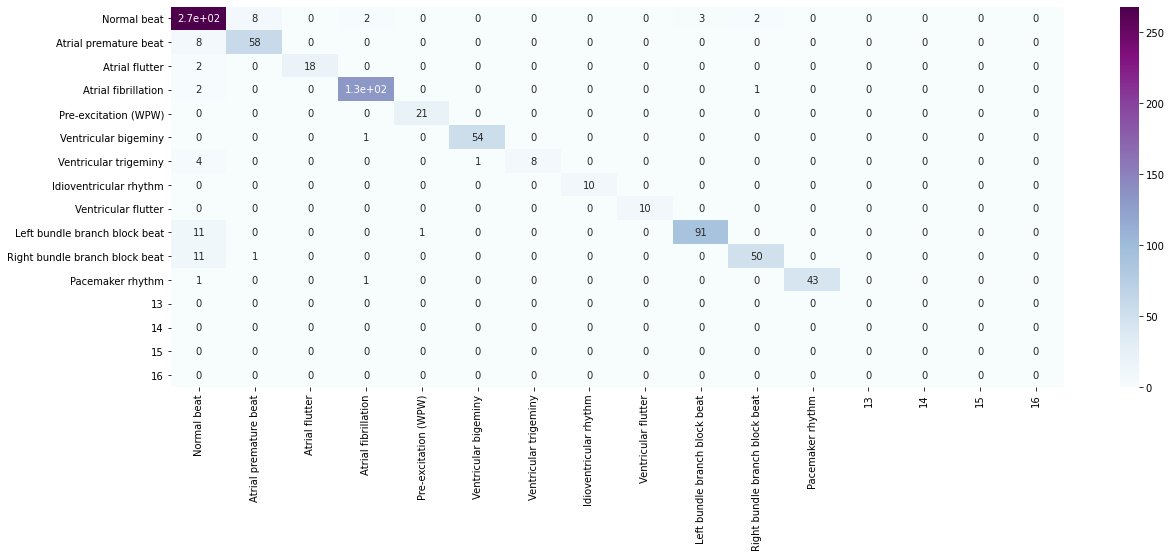

In [821]:
from matplotlib import pyplot
import seaborn as sn
df_cm = pd.DataFrame(truth_prediction_matrix.numpy(),
                    #  index = [i for i in list(dict_mapping.values())],
                    #  columns = [i for i in list(dict_mapping.values())])
                     index = [i for i in list(dict_mapping.keys())],
                     columns = [i for i in list(dict_mapping.keys())])
pyplot.figure(figsize = (20,7))
sn.heatmap(df_cm, annot=True, cmap="BuPu")